## Import và Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms,datasets
from torchvision.transforms import InterpolationMode

import random

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


## Data Augmentation

In [2]:
# resize về 350x350 pixels
img_height, img_width = 350, 350 

data_transforms = {
    'train': transforms.Compose([
        # Resize
        transforms.Resize(
            (img_height, img_width),
            interpolation=InterpolationMode.BILINEAR
        ),
        
        # Rotation ±15 độ + shift + zoom (scale)
        transforms.RandomAffine(
            degrees=15,                      # Xoay ngẫu nhiên từ -15 đến +15 độ
            translate=(0.1, 0.1),             # Xoay ngẫu nhiên từ -15 đến +15 độ
            scale=(0.9, 1.1),                 # Zoom in/out ngẫu nhiên từ 90% đến 110%
            fill=0                          
        ),

        # Flip
        transforms.RandomHorizontalFlip(p=0.5),  # 50% xác suất lật ngang
        transforms.RandomVerticalFlip(p=0.5), # 50% xác suất lật dọc
        # Brightness
        transforms.ColorJitter(
            brightness=(0.85, 1.15) # Độ sáng từ 85% đến 115% so với gốc
        ),
        # Padding reflect để giống fill_mode='reflect'
        transforms.Pad(
            padding=10, #Thêm 10 pixels mỗi cạnh
            padding_mode='reflect' # Sao chép phản chiếu từ biên (tự nhiên hơn)
        ),
        transforms.CenterCrop((img_height, img_width)), # Crop về kích thước gốc

        # Tensor + Normalize ImageNet
        transforms.ToTensor(), # Chuyển sang Tensor
        transforms.Normalize( # Normalize theo ImageNet
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),

    'val': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


## Load Data

In [3]:
data_dir = '/kaggle/input/bean-leaf-lesions-classification'

#Dictionary chứa 2 ImageFolder datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}

train_loader = dataloaders['train']
val_loader = dataloaders['val']

# Đếm số lượng ảnh trong mỗi tập
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Lấy danh sách tên classes
class_names = image_datasets['train'].classes
# Lấy mapping từ class name sang index
class_to_idx = image_datasets['train'].class_to_idx  

print(f"Classes: {class_names}")
print(f"Số lượng ảnh Train: {dataset_sizes['train']}")
print(f"Số lượng ảnh Val: {dataset_sizes['val']}")

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Số lượng ảnh Train: 1034
Số lượng ảnh Val: 133


## Build Model

In [6]:
# EFFICIENTNET-B3 (TRANSFER LEARNING)
def build_model(num_classes):
    
    # Tải model EfficientNet-B3 đã pre-trained
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

    # Unfreeze các layers (cho phép fine-tuning)
    for param in model.features.parameters():
        param.requires_grad = True 

    # Thay thế lớp Classifier cuối cùng
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

# Khởi tạo model
model = build_model(num_classes=len(class_names))
model = model.to(device)

print("✓ Model EfficientNetB3 đã được khởi tạo")
print(f"✓ Số lớp output: {len(class_names)}")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 168MB/s]


✓ Model EfficientNetB3 đã được khởi tạo
✓ Số lớp output: 3


## Early Stopping

In [7]:
# EARLY STOPPING
class EarlyStopping:
    
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        # Epoch đầu tiên 
        if self.best_score is None:
            self.best_score = score 
            self.save_checkpoint(val_loss, model)
            
        # Score hiện tại KHÔNG tốt hơn best
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        # Score hiện tại TỐT HƠN best
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## CONFIG Optimizer

In [8]:
# Hàm mất mát: CrossEntropyLoss 
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

## Training Functions

In [9]:
# Training Function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Validation Function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

## Training Loop

In [10]:
NUM_EPOCHS = 30

# Khởi tạo Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth')

# Lưu trữ metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("=" * 60)
print("BẮT ĐẦU HUẤN LUYỆN")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n⚠ Early stopping triggered!")
        break

print("\n" + "=" * 60)
print("HOÀN THÀNH HUẤN LUYỆN")
print("=" * 60)

BẮT ĐẦU HUẤN LUYỆN

Epoch 1/30
----------------------------------------
Train Loss: 0.6388 | Train Acc: 0.7563
Val Loss:   0.1950 | Val Acc:   0.9173
Validation loss decreased (inf → 0.194953). Saving model...

Epoch 2/30
----------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.1576 | Train Acc: 0.9449
Val Loss:   0.1003 | Val Acc:   0.9624
Validation loss decreased (0.194953 → 0.100266). Saving model...

Epoch 3/30
----------------------------------------
Train Loss: 0.0759 | Train Acc: 0.9710
Val Loss:   0.1207 | Val Acc:   0.9549
EarlyStopping counter: 1/5

Epoch 4/30
----------------------------------------
Train Loss: 0.0483 | Train Acc: 0.9816
Val Loss:   0.0251 | Val Acc:   0.9925
Validation loss decreased (0.100266 → 0.025065). Saving model...

Epoch 5/30
----------------------------------------
Train Loss: 0.0580 | Train Acc: 0.9787
Val Loss:   0.0515 | Val Acc:   0.9850
EarlyStopping counter: 1/5

Epoch 6/30
----------------------------------------
Train Loss: 0.0338 | Train Acc: 0.9884
Val Loss:   0.0514 | Val Acc:   0.9774
EarlyStopping counter: 2/5

Epoch 7/30
----------------------------------------
Train Loss: 0.0481 | Train Acc: 0.9836
Val Loss:   0.0257 | Val Acc:   0.9925
EarlyStopping counter: 3/5

Epoch 8/30
-----------------

## Đánh giá

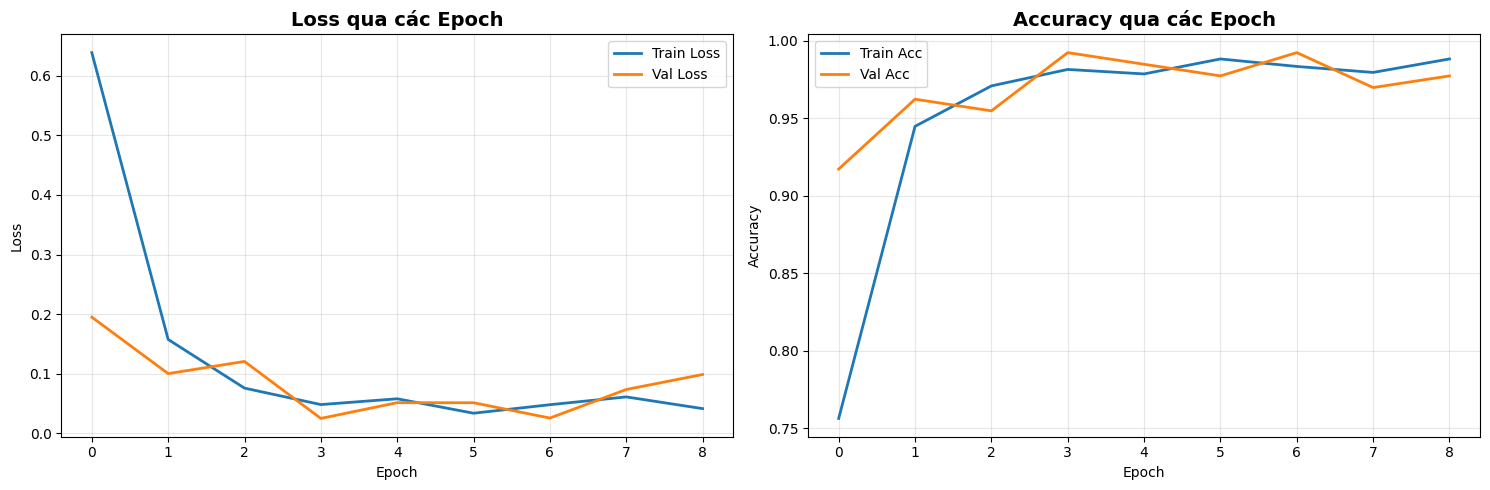

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss qua các Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', linewidth=2)
axes[1].set_title('Accuracy qua các Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


✓ Best model loaded!

VALIDATION SET - CLASSIFICATION REPORT
                   precision    recall  f1-score   support

angular_leaf_spot       1.00      0.98      0.99        44
        bean_rust       1.00      1.00      1.00        45
          healthy       0.98      1.00      0.99        44

         accuracy                           0.99       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.99      0.99      0.99       133



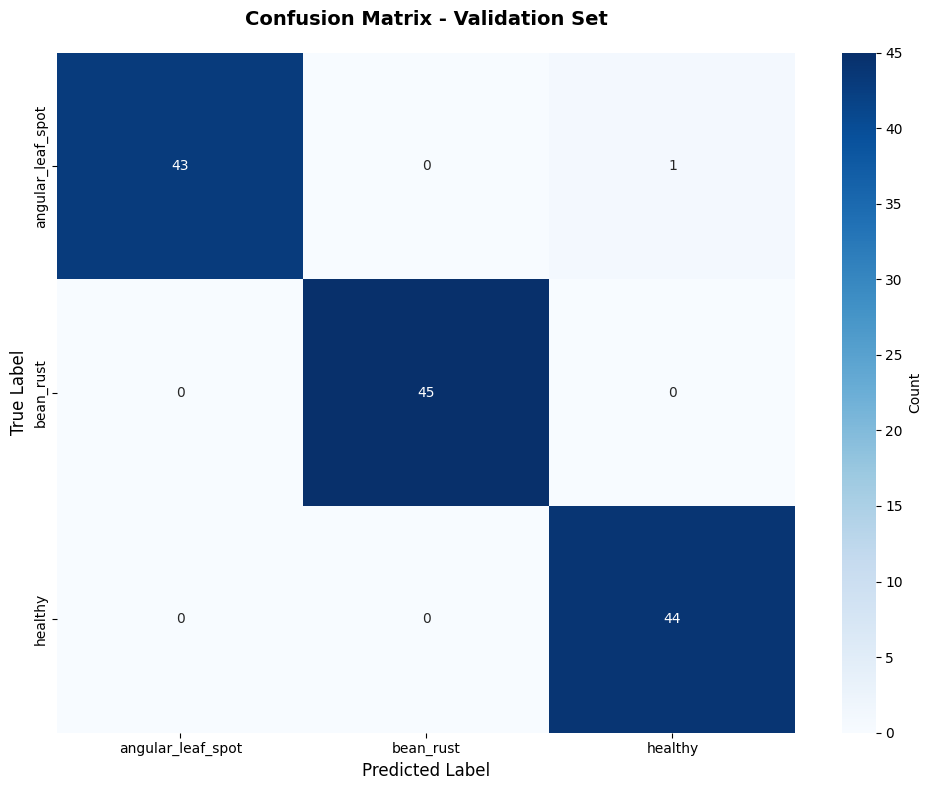

In [12]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("✓ Best model loaded!\n")

# Đánh giá trên Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("=" * 60)
print("VALIDATION SET - CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=list(class_to_idx.keys()),
    digits=2
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()